# Why are single grid points in the online run blowing up?

The online runs keep crashing because single grid points will develop astronomically high heating rates which eventually crashes the model. 

Let's really dig into the data and find out why the hell this is happening!

For the analysis we will use several ingredients:
- Output from two runs that blow up with different networks
    - Debug 25: One layer network, crashed on day 10
    - Debug 29: 10 layer network, crashed on day 2
- The actual keras networks
- A reference SP-CAM simulations with the same output.
    - Debug 30: But note that this run also has the energy fixer removed.
- A statistics file for the entire training dataset containing means, maxs, etc.

I already checked that the networks in the Fortran code are producing the correct output, so we can rule out errors in the implementation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *

/home1/05488/tg847872/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def get_model_preds(m, inps):
    return m.predict(inps.reshape(152, -1).T).T.reshape(120, 64, 128)

## Load the datasets

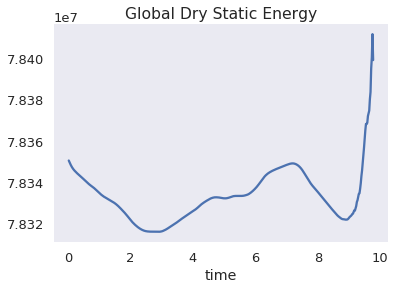

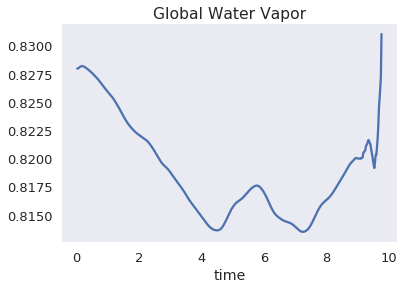

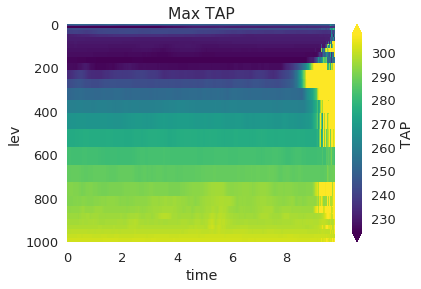

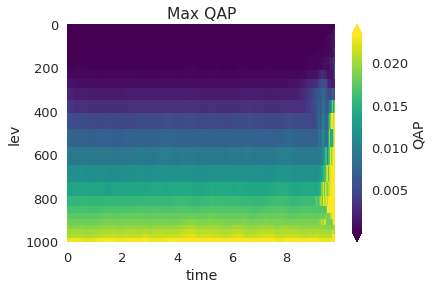

In [42]:
d25 = basic_debug('debug25')

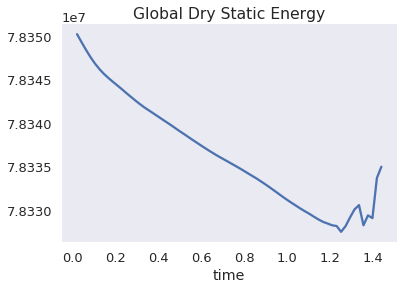

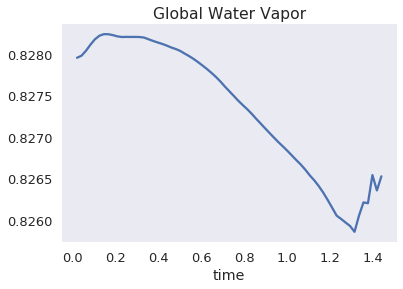

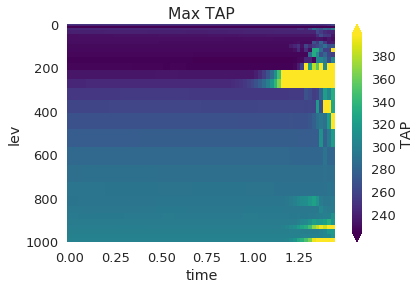

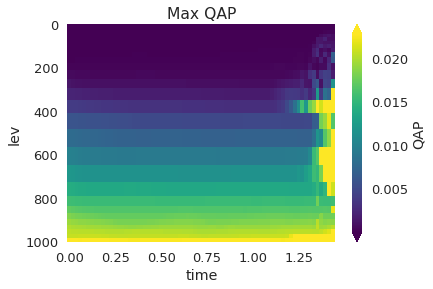

In [46]:
d29 = basic_debug('debug29')

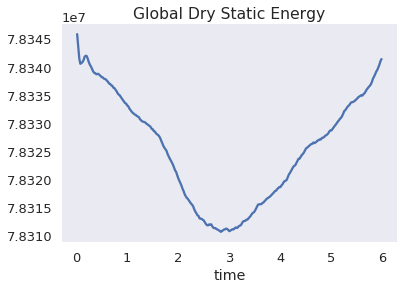

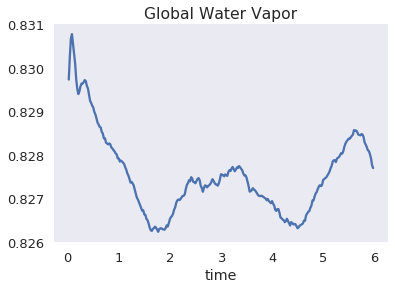

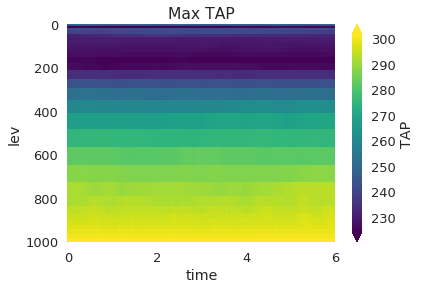

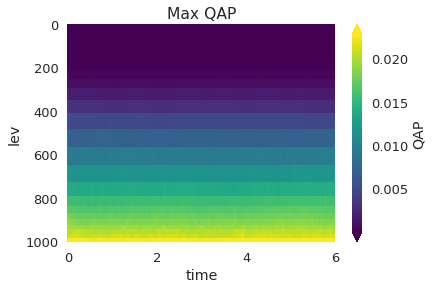

In [5]:
d30 = basic_debug('debug30')

In [43]:
norm = xr.open_dataset('/home1/05488/tg847872/tmp/purecrm_essv2_nonorm_train_sample1_norm.nc')

In [44]:
max_rs = np.maximum(norm['feature_stds_by_var'], norm['feature_maxs'] - norm['feature_mins'])

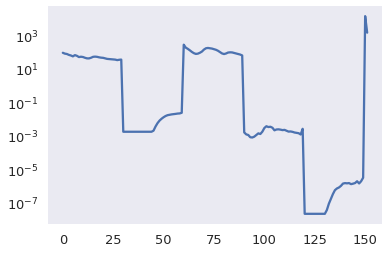

In [10]:
plt.plot(max_rs); plt.gca().set_yscale('log')

In [45]:
inp_max = (norm['feature_maxs'] - norm['feature_means'])  / max_rs; 
inp_min = (norm['feature_mins'] - norm['feature_means']) / max_rs
outp_max = norm['target_maxs'] * norm['target_conv']; outp_min = norm['target_mins'] * norm['target_conv']

In [4]:
m25 = keras.models.load_model('/home1/05488/tg847872/tmp/B018_purecrm_essv2_nonorm_sample1_max_rs.h5')
m25.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               78336     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 139,896
Trainable params: 139,896
Non-trainable params: 0
_________________________________________________________________


In [4]:
m29 = keras.models.load_model('/home1/05488/tg847872/tmp/B023_purecrm_essv2_nonorm_sample1_noise1_deep1.h5')
m29.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               39168     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

In [295]:
mB024 = keras.models.load_model('/home1/05488/tg847872/tmp/B024_purecrm_essv2_nonorm_sample1_noise2_deep1.h5')
mB024.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               39168     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

In [296]:
mB022 = keras.models.load_model('/home1/05488/tg847872/tmp/B022_purecrm_essv2_nonorm_sample1_dr2_deep.h5')
mB022.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               78336     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               61560     
Total params: 402,552
Trainable params: 402,552
Non-trainable params: 0
_________________________________________________________________


## Find and analyze the crash point

For now let's focus on Debug 29. Let's find the crash point and analyze when it started going wrong. 

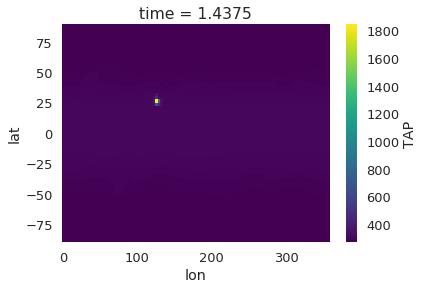

In [26]:
d29['TAP'].isel(time=-1).max('lev').plot();

In [49]:
# Get the coordinates of this point
ilev, ilat, ilon = get2Didxs(d29['TAP'].isel(time=-1), np.argmax); ilev, ilat, ilon

(13, 41, 45)

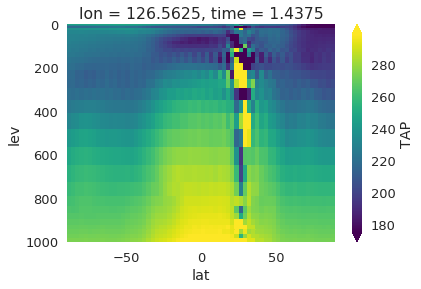

In [30]:
d29['TAP'].isel(lon=ilon, time=-1).plot(yincrease=False, robust=True);

### How early does it go wrong?

Let's try to find the starting point of the crazy values. Let's also find a grid point nearby that behaves normally. Blue is the crash point, green a point 5 grid boxes away.

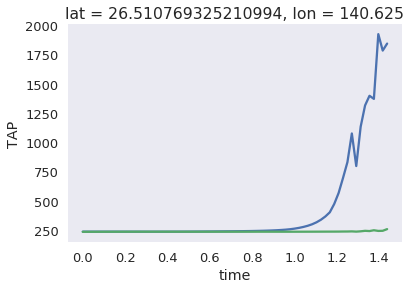

In [42]:
d29['TAP'].isel(lat=ilat, lon=ilon, lev=range(15)).max('lev').plot();
d29['TAP'].isel(lat=ilat, lon=ilon+5, lev=range(15)).max('lev').plot();

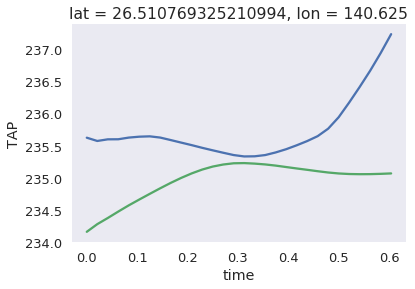

In [100]:
# Zoom in
d29['TAP'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(0, 30)).max('lev').plot();
d29['TAP'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(0, 30)).max('lev').plot();

So at around 0.4 days (time step 20) we see an increase in the temperature. Let's now check some the outputs of the network and also the humidity.

FYI: Checking the minimum values instead of the max shows anomalies much later, so positive perturbations seem to be the original issue.

### Network inputs for this point around the explosion starting point

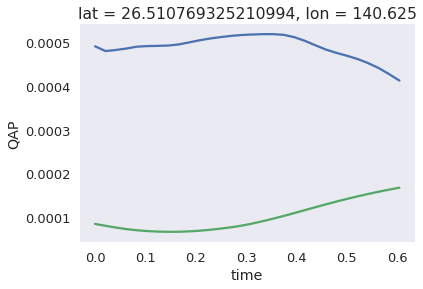

In [101]:
d29['QAP'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(0, 30)).max('lev').plot();
d29['QAP'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(0, 30)).max('lev').plot();

So this is interesting. The maximum QAP is much higher at this grid point than at the point that does not explode. Is this unusual? NNQC is what the network actually sees. It is QAP[t-1] - VD01[t-1].

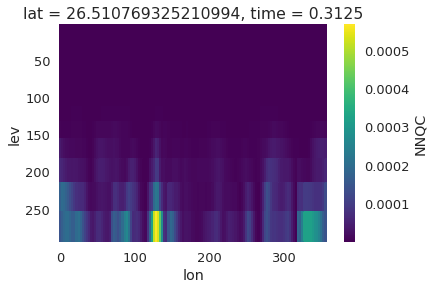

In [82]:
d29['NNQC'].isel(time=15, lat=ilat, lev=range(15)).plot(yincrease=False);

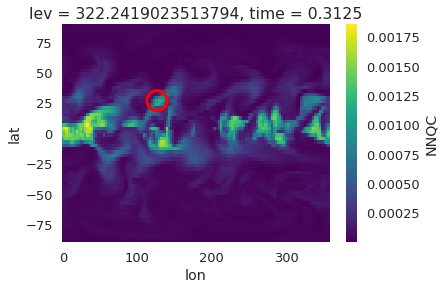

In [90]:
d29['NNQC'].isel(time=15, lev=15).plot()
plt.scatter(d29.lon[ilon], d29.lat[ilat], s=400, linewidths=3, edgecolors='red', facecolors='none')

So for the given latitude the humidity is a lot at upper levels, but not globally.

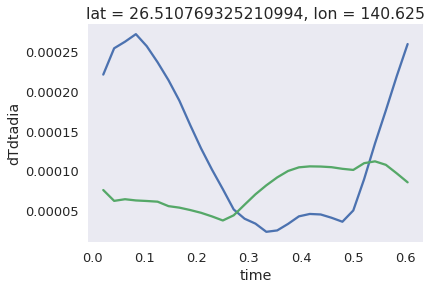

In [102]:
d29['dTdtadia'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(1, 30)).max('lev').plot();
d29['dTdtadia'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(1, 30)).max('lev').plot();

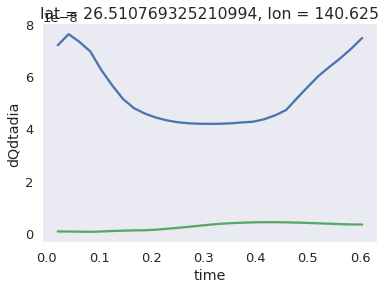

In [103]:
d29['dQdtadia'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(1, 30)).max('lev').plot();
d29['dQdtadia'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(1, 30)).max('lev').plot();

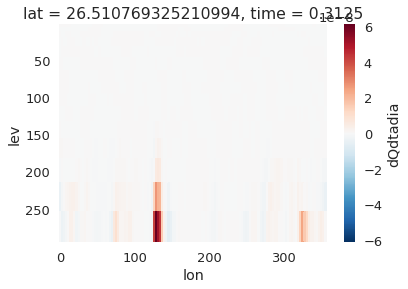

In [84]:
d29['dQdtadia'].isel(time=15, lat=ilat, lev=range(15)).plot(yincrease=False);

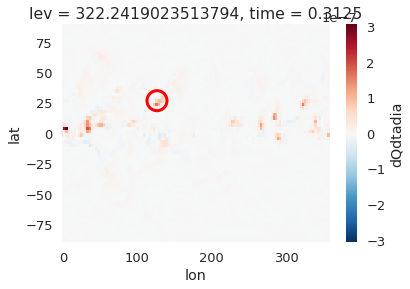

In [85]:
d29['dQdtadia'].isel(time=15, lev=15).plot()
plt.scatter(d29.lon[ilon], d29.lat[ilat], s=400, linewidths=3, edgecolors='red', facecolors='none')

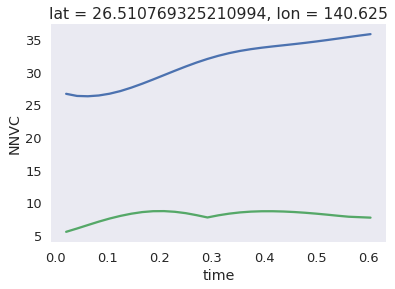

In [104]:
d29['NNVC'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(1, 30)).max('lev').plot();
d29['NNVC'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(1, 30)).max('lev').plot();

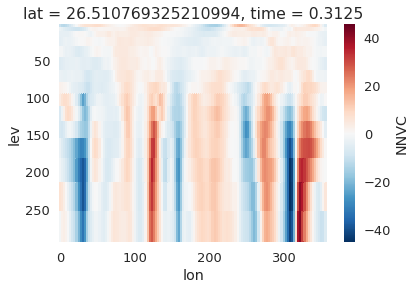

In [86]:
d29['NNVC'].isel(time=15, lat=ilat, lev=range(15)).plot(yincrease=False);

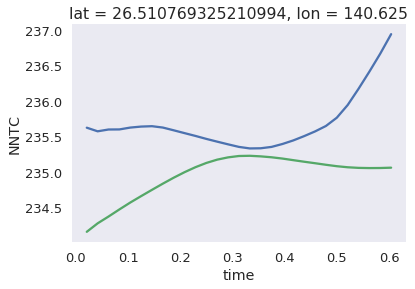

In [105]:
d29['NNTC'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(1, 30)).max('lev').plot();
d29['NNTC'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(1, 30)).max('lev').plot();

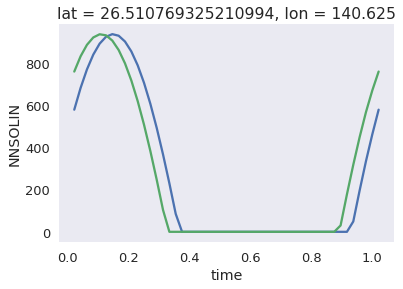

In [87]:
d29['NNSOLIN'].isel(lat=ilat, lon=ilon, time=range(1, 50)).plot();
d29['NNSOLIN'].isel(lat=ilat, lon=ilon+5, time=range(1, 50)).plot();

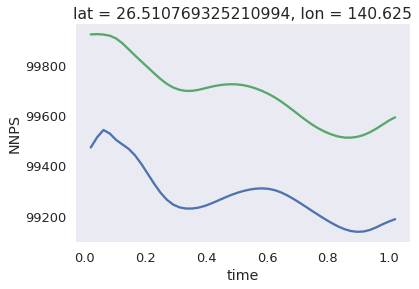

In [88]:
d29['NNPS'].isel(lat=ilat, lon=ilon, time=range(1, 50)).plot();
d29['NNPS'].isel(lat=ilat, lon=ilon+5, time=range(1, 50)).plot();

**Summary**

This point definitely has some large values for this latitude, but nothing unseen at lower latitudes. 

BUT: The anomalies could be anywhere, eg the surface. For now let's look at the CBRAIN outputs

### CBRAIN outputs: Where is it going wrong?

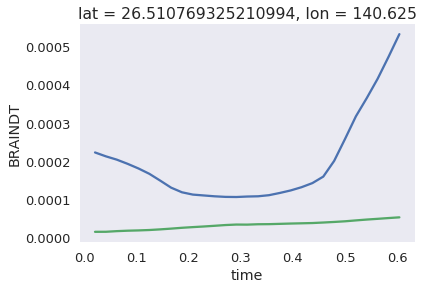

In [94]:
d29['BRAINDT'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(1, 30)).max('lev').plot();
d29['BRAINDT'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(1, 30)).max('lev').plot();

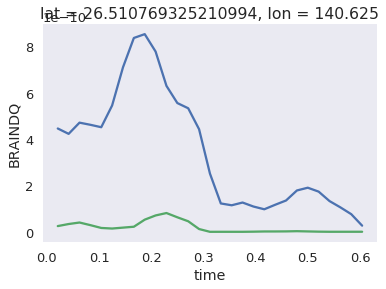

In [97]:
d29['BRAINDQ'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(1, 30)).max('lev').plot();
d29['BRAINDQ'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(1, 30)).max('lev').plot();

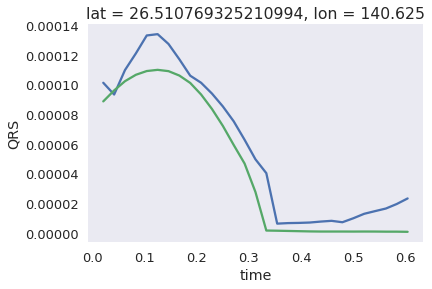

In [95]:
d29['QRS'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(1, 30)).max('lev').plot();
d29['QRS'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(1, 30)).max('lev').plot();

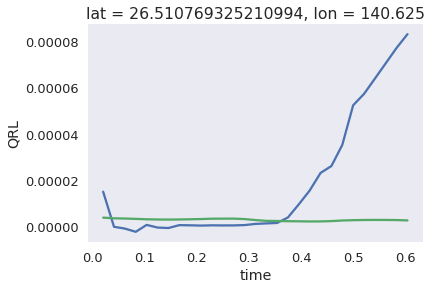

In [96]:
d29['QRL'].isel(lat=ilat, lon=ilon, lev=range(15), time=range(1, 30)).max('lev').plot();
d29['QRL'].isel(lat=ilat, lon=ilon+5, lev=range(15), time=range(1, 30)).max('lev').plot();

OHA! QRL lights up earlier than BRAINDT, but remember that the order of magnitude is much smaller. 

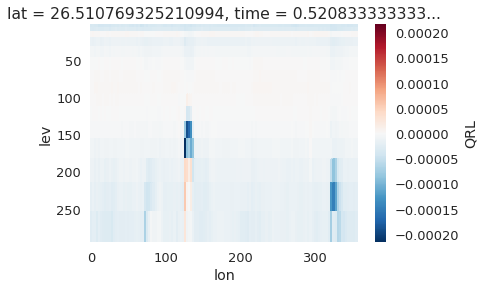

In [106]:
d29['QRL'].isel(time=25, lat=ilat, lev=range(15)).plot(yincrease=False);

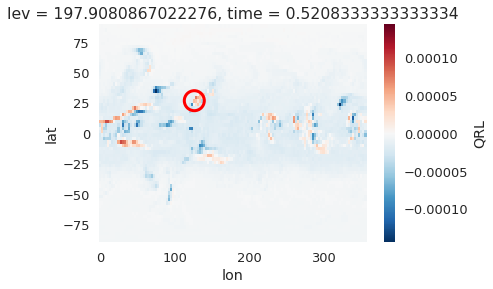

In [107]:
d29['QRL'].isel(time=25, lev=12).plot()
plt.scatter(d29.lon[ilon], d29.lat[ilat], s=400, linewidths=3, edgecolors='red', facecolors='none')

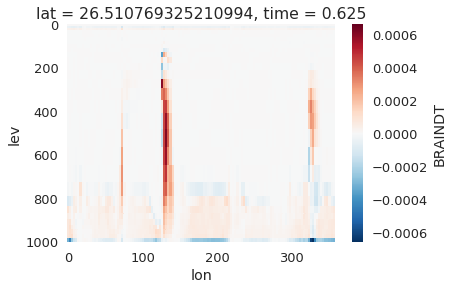

In [120]:
d29['BRAINDT'].isel(time=30, lat=ilat).plot(yincrease=False);

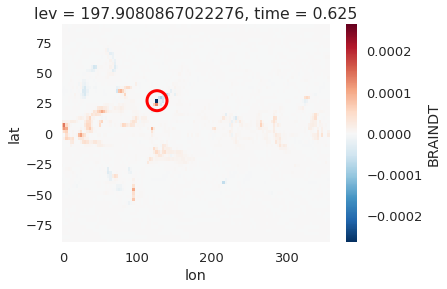

In [110]:
d29['BRAINDT'].isel(time=30, lev=12).plot()
plt.scatter(d29.lon[ilon], d29.lat[ilat], s=400, linewidths=3, edgecolors='red', facecolors='none');

So at time step 30 we are already seing unrealistic structures. When can we first detect them?

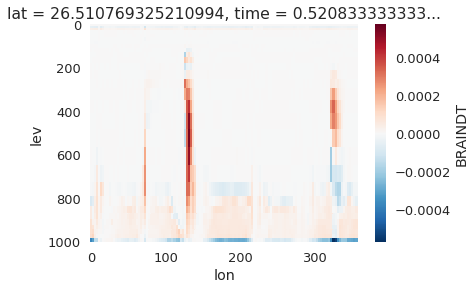

In [116]:
d29['BRAINDT'].isel(time=25, lat=ilat).plot(yincrease=False);

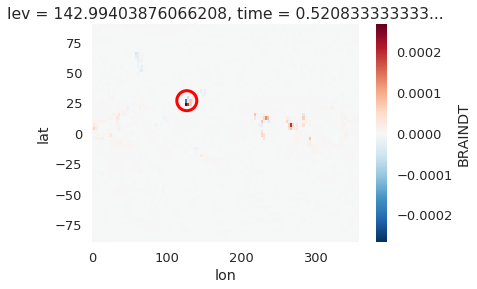

In [125]:
d29['BRAINDT'].isel(time=25, lev=10).plot()
plt.scatter(d29.lon[ilon], d29.lat[ilat], s=400, linewidths=3, edgecolors='red', facecolors='none');

I think what we have to look at are the structures in the upper few layers. The heating throught the troposphere is not that anomalous, but the dipole heating structures above 200hPa will eventually blow up as such:

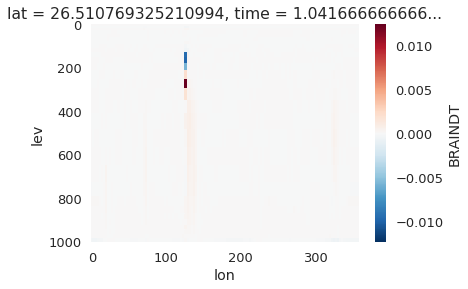

In [127]:
d29['BRAINDT'].isel(time=50, lat=ilat).plot(yincrease=False);

## Load the actual model, feed it the normalized inputs and experiment why we get these damn heating rates

In [47]:
t=30  # time to analyze

In [48]:
inps = get_cb_inps(d29, t, norm['feature_means'].values, max_rs.values)

In [321]:
inps.shape

(152, 64, 128)

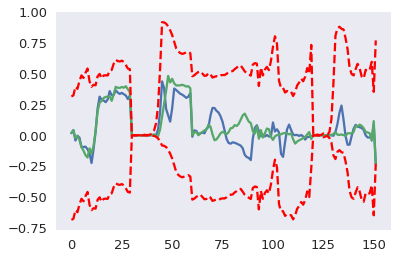

In [50]:
plt.plot(inps[:, ilat, ilon])
plt.plot(inps[:, ilat, ilon+5]);
plt.plot(inp_min, ls='--', c='r'); plt.plot(inp_max, ls='--', c='r');

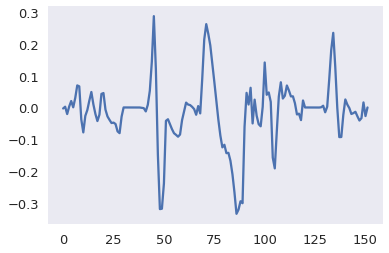

In [323]:
plt.plot(inps[:, ilat, ilon]- inps[:, ilat, ilon+5]);

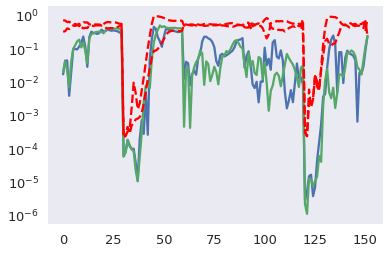

In [324]:
plt.plot(np.abs(inps[:, ilat, ilon]))
plt.plot(np.abs(inps[:, ilat, ilon+5]));
plt.plot(np.abs(inp_min), ls='--', c='r'); plt.plot(np.abs(inp_max), ls='--', c='r');
plt.gca().set_yscale('log')

So it is not tiny values where the inputs are usually zero.

In [61]:
outps = stack_outps(d29, t)   # Outputs in energy units!

In [326]:
outps.shape

(120, 64, 128)

In [328]:
mypreds = get_model_preds(m29, inps)

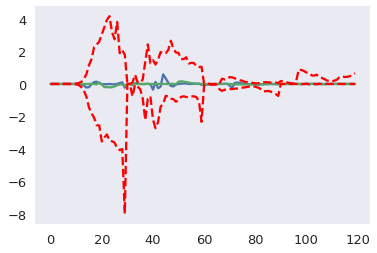

In [329]:
plt.plot(outps[:, ilat, ilon])
plt.plot(outps[:, ilat, ilon+5]);
# Check if the outputs are correct
#plt.plot(mypreds[:, ilat, ilon]) #--> Yes it is correct
plt.plot(outp_min, ls='--', c='r'); plt.plot(outp_max, ls='--', c='r');

In [330]:
raw_inps = inps[:, ilat, ilon]
raw_inps2 = inps[:, ilat, ilon+5]

In [331]:
my_inps = raw_inps.copy()

In [332]:
my_inps[120:150] = raw_inps2[120:150]

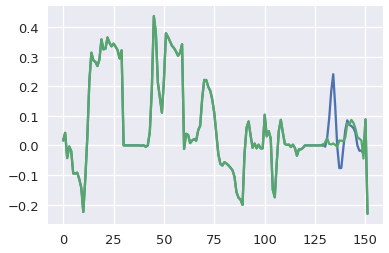

In [333]:
plt.plot(raw_inps)
plt.plot(my_inps)
plt.grid()

In [338]:
pltlevs = np.arange(30, 60)

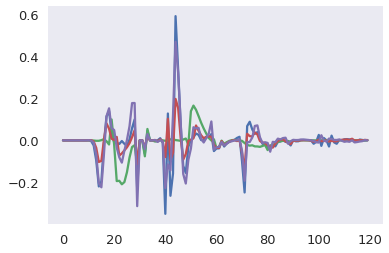

In [335]:
plt.plot(outps[:, ilat, ilon])
plt.plot(outps[:, ilat, ilon+5]);
plt.plot(m29.predict(my_inps.reshape(1, -1))[0]);
plt.plot(m25.predict(raw_inps.reshape(1, -1))[0]);

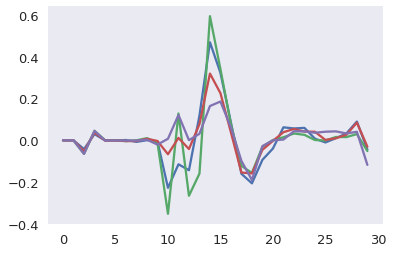

In [339]:
plt.plot(m25.predict(raw_inps.reshape(1, -1))[0][pltlevs]);
plt.plot(m29.predict(raw_inps.reshape(1, -1))[0][pltlevs]);
plt.plot(mB022.predict(raw_inps.reshape(1, -1))[0][pltlevs]);
plt.plot(mB024.predict(raw_inps.reshape(1, -1))[0][pltlevs]);

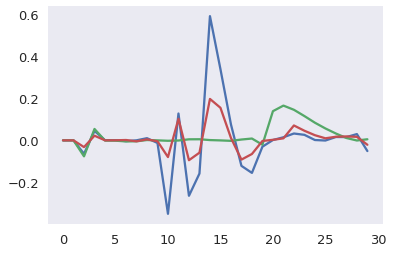

In [340]:
plt.plot(outps[pltlevs, ilat, ilon])
plt.plot(outps[pltlevs, ilat, ilon+5]);
plt.plot(m29.predict(my_inps.reshape(1, -1))[0][pltlevs]);

At time step 30, T and Q have a little impact, V has no impact, dTdtadiab doesn't have the hugest impact, but dQdtadiab is really really influential! SOLING and PS have no impact!

So dQdtadiab seems to have a really large influence on the predictions of BRAINDT.

Which levels of dQdtadiab are we talking about? I guess mostly the upper 15-20 levels. So most of it...

But that is not the whole story. It is not that simple...

We see the onset of the blow up early, but the inputs and outputs are not outside the training range. So a limiter would not prevent the problem from happening.


It seems to be most sensitive to dQdtadiab.

Also, the two different networks react similarly hinting. So it's not the architecture. Even though m29 seems to be the most affected.

## Look at weights

Are some inputs weighted much more than others?

In [7]:
weights = m25.get_weights(); weights[0].shape

(152, 512)

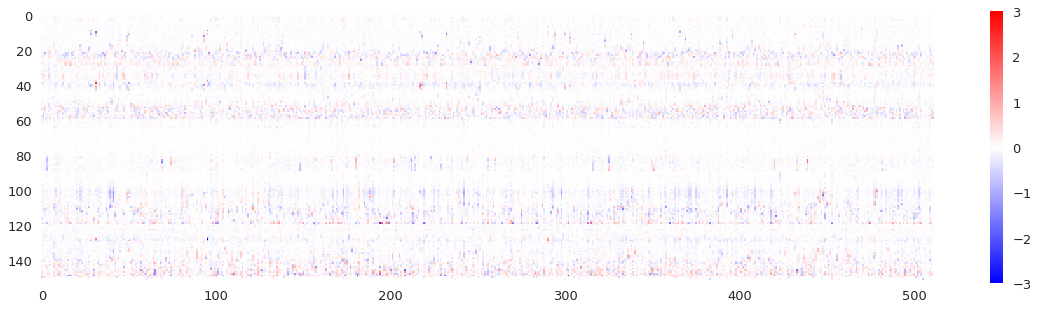

In [21]:
fig = plt.figure(figsize=(20,10)); plt.imshow(weights[0], cmap='bwr', vmin=-3, vmax=3); plt.colorbar(shrink=0.5)

In [15]:
ml2 = keras.models.load_model('/home1/05488/tg847872/tmp/l2test.h5')

In [16]:
weights2 = ml2.get_weights()

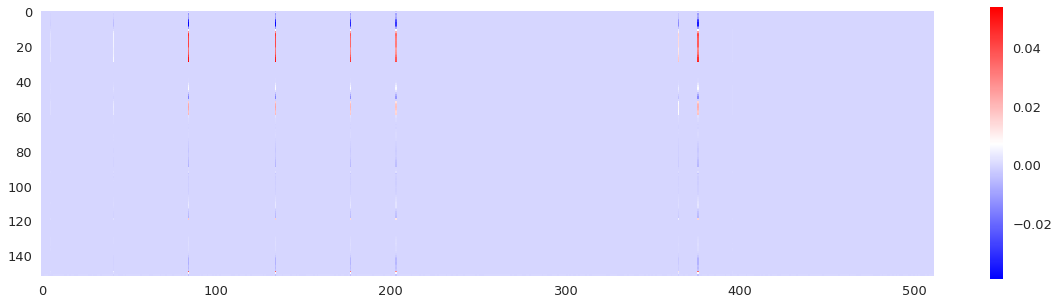

In [17]:
fig = plt.figure(figsize=(20,10)); plt.imshow(weights2[0], cmap='bwr'); plt.colorbar(shrink=0.5)

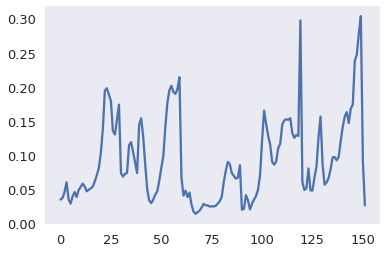

In [11]:
plt.plot(np.mean(np.abs(weights[0]), 1))

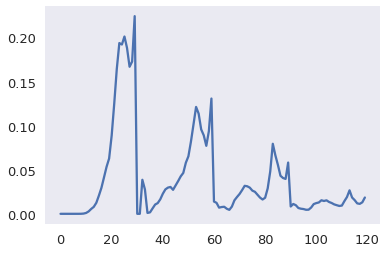

In [14]:
plt.plot(np.mean(np.abs(weights[2]), 0))

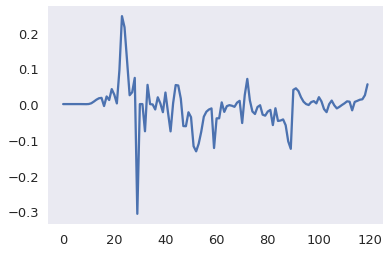

In [15]:
plt.plot(weights[3])

So the large values are at BRAINDT level 13. 

In [14]:
weights[2].shape

(512, 120)

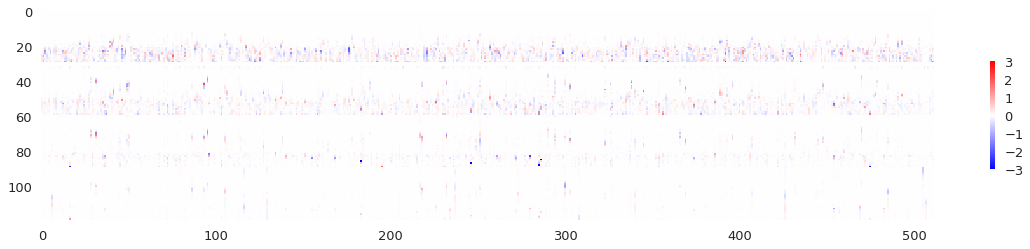

In [20]:
fig = plt.figure(figsize=(20,10)); plt.imshow(weights[2][:,:].T, cmap='bwr', vmin=-3, vmax=3); 
plt.colorbar(shrink=0.2)

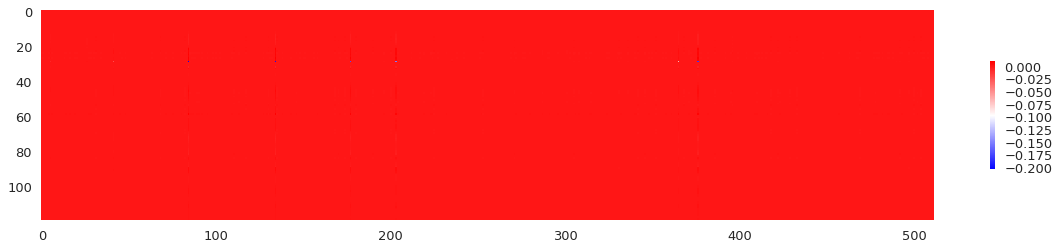

In [18]:
fig = plt.figure(figsize=(20,10)); plt.imshow(weights2[2][:,:].T, cmap='bwr'); 
plt.colorbar(shrink=0.2)

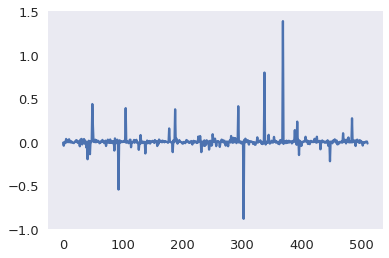

In [36]:
plt.plot(weights[2][:, 30+14])

In [72]:
a = weights[2][:, 30+13]; a.shape

(512,)

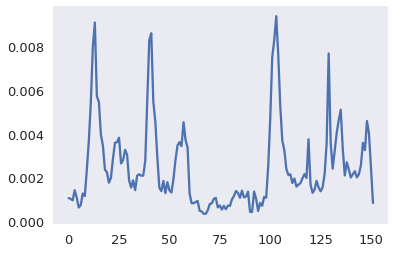

In [52]:
plt.plot(np.abs((a*weights[0])).mean(1));
#plt.plot(np.mean(np.abs(weights[0]), 1))

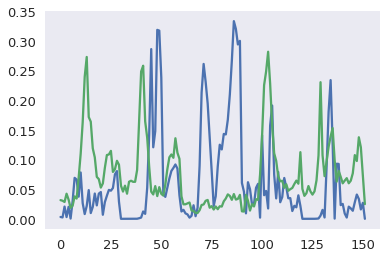

In [60]:
plt.plot(np.abs(inps[:, ilat, ilon] - inps[:, ilat, ilon+5]))
plt.plot(np.abs((a*weights[0])).mean(1)*30);

In [63]:
o25 = stack_outps(d25, t)

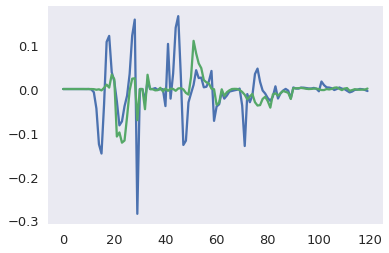

In [64]:
plt.plot(o25[:, ilat, ilon])
plt.plot(o25[:, ilat, ilon+5]);

In [74]:
def act(inp, weights):
    x = np.dot(inp, weights[0]) + weights[1]
    return np.maximum(x, 0.3*x)

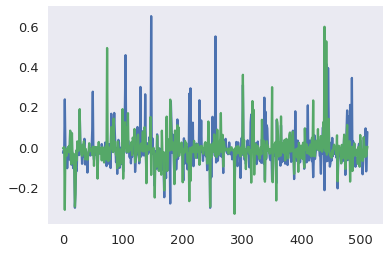

In [75]:
plt.plot(act(inps[:, ilat, ilon], weights))
plt.plot(act(inps[:, ilat, ilon+5], weights))

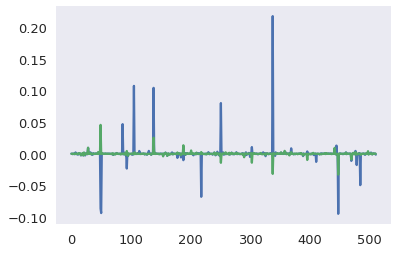

In [76]:
plt.plot(act(inps[:, ilat, ilon], weights)*a)
plt.plot(act(inps[:, ilat, ilon+5], weights)*a)

In [77]:
np.argmax(act(inps[:, ilat, ilon], weights)*a)

338

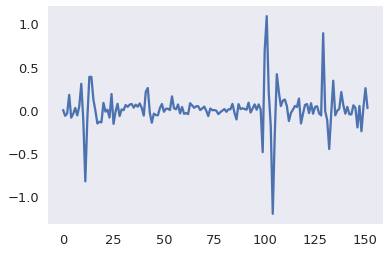

In [80]:
plt.plot(weights[0][:, 338])

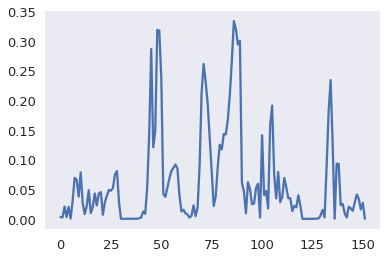

In [81]:
plt.plot(np.abs(inps[:, ilat, ilon] - inps[:, ilat, ilon+5]))